In [1]:
# Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import joblib
import itertools

warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import lightgbm
from catboost import CatBoostClassifier


In [3]:
# Set seed for reproducibility
import random
import numpy as np
import tensorflow as tf

SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)


In [4]:
# Load dataset
df = pd.read_csv('cleaned_dataset.csv')

# Define the features and the target class
x = df.drop(columns=['target'], axis=1)
y = df['target']

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)

In [5]:
#distribution of training and testing data
print('Distribution of target class in training data')
print(y_train.value_counts())
print('Distribution of target class in testing data')
print(y_test.value_counts())

Distribution of target class in training data
target
0    33019
1     1584
Name: count, dtype: int64
Distribution of target class in testing data
target
0    14147
1      683
Name: count, dtype: int64


In [6]:
# Load the saved models 
model_paths = [
    'CatBoost.pkl',
    'DecisionTree.pkl',
    'KNN.pkl',
    'RandomForest.pkl',
    'XGBoost.pkl'
]

models = [joblib.load(path) for path in model_paths if hasattr(joblib.load(path), 'fit')]

model_names = [f'model_{i+1}' for i in range(len(models))]
estimators = list(zip(model_names, models))

In [7]:
# Define final estimators
final_estimators = [
    ('Logistic', LogisticRegression()),
    ('RandomForest', RandomForestClassifier()),
    ('GradientBoosting', GradientBoostingClassifier()),
    ('KNeighbors', KNeighborsClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('XGBoost', XGBClassifier()),
    ('GaussianNB', GaussianNB()),
    ('MLP', MLPClassifier()),
    ('LightGBM', lightgbm.LGBMClassifier(verbose=0))
]

In [8]:
best_score = 0
best_model = None
best_final_estimator = None
best_combination = None

total_combinations = sum([len(list(itertools.combinations(estimators, i))) for i in range(2, len(estimators) + 1)]) * len(final_estimators)
print(f'Total combinations: {total_combinations}')
count = 1

for final_estimator_name, final_estimator in final_estimators:
    for i in range(2, len(estimators) + 1):
        for combination in itertools.combinations(estimators, i):
            # Extract model names for printing
            model_names = tuple(model[0] for model in combination)
            print(f'{count} Testing combination: {model_names} with final estimator: {final_estimator_name}')
            stacking = StackingClassifier(estimators=list(combination), final_estimator=final_estimator, verbose=0)
            stacking.fit(x_train, y_train)
            y_pred = stacking.predict(x_test)
            score = accuracy_score(y_test, y_pred)
            if score > best_score:
                best_score = score
                best_model = stacking
                best_final_estimator = final_estimator_name
                best_combination = model_names
            count += 1

print(f'Best model: {best_combination} with final estimator: {best_final_estimator}')
print(f'Best score: {best_score}')

Total combinations: 234
1 Testing combination: ('model_1', 'model_2') with final estimator: Logistic
2 Testing combination: ('model_1', 'model_3') with final estimator: Logistic
3 Testing combination: ('model_1', 'model_4') with final estimator: Logistic
4 Testing combination: ('model_1', 'model_5') with final estimator: Logistic
5 Testing combination: ('model_2', 'model_3') with final estimator: Logistic
6 Testing combination: ('model_2', 'model_4') with final estimator: Logistic
7 Testing combination: ('model_2', 'model_5') with final estimator: Logistic
8 Testing combination: ('model_3', 'model_4') with final estimator: Logistic
9 Testing combination: ('model_3', 'model_5') with final estimator: Logistic
10 Testing combination: ('model_4', 'model_5') with final estimator: Logistic
11 Testing combination: ('model_1', 'model_2', 'model_3') with final estimator: Logistic
12 Testing combination: ('model_1', 'model_2', 'model_4') with final estimator: Logistic
13 Testing combination: ('m

Test Accuracy: 95.71%

Accuracy:  95.71139581928523
Recall:  95.71139581928523
Precision:  94.93340928826738
F1-Score:  94.10559685736361


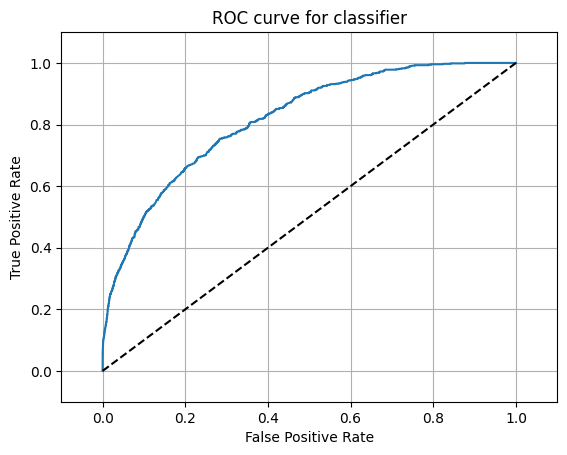

AUC Score: 0.8175971997022272


In [9]:
# Evaluate the stacking ensemble
y_pred_train = best_model.predict(x_train)
y_pred_test = best_model.predict(x_test)

train_accuracy = accuracy_score(y_train, y_pred_train) * 100
test_accuracy = accuracy_score(y_test, y_pred_test) * 100

print(f"Test Accuracy: {test_accuracy:.2f}%\n")

print('Accuracy: ', accuracy_score(y_test, y_pred_test) * 100)
print('Recall: ', recall_score(y_test, y_pred_test, average='weighted') * 100)
print('Precision: ', precision_score(y_test, y_pred_test, average='weighted') * 100)
print('F1-Score: ', f1_score(y_test, y_pred_test, average='weighted') * 100)

# Compute ROC curve and AUC score
y_pred_prob = best_model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('ROC curve for classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

print("AUC Score:", roc_auc_score(y_test, y_pred_prob))


<Figure size 800x600 with 0 Axes>

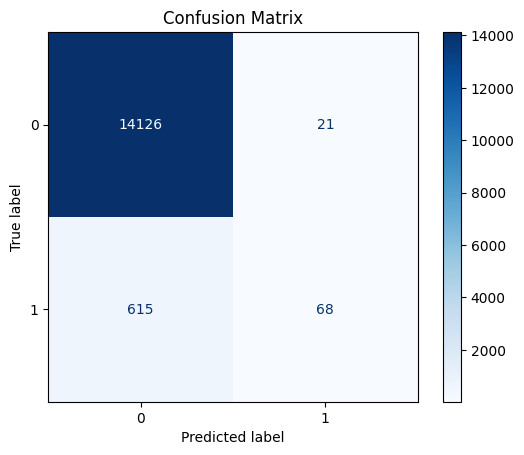

In [10]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
cm_display.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [11]:
# Save the stacking model
stacking_model_file = "Ensemble models\V1_Ensemble_stacking_model_imb.pkl"
joblib.dump(best_model, stacking_model_file)

# Load and test the saved model
loaded_stacking_model = joblib.load(stacking_model_file)
print('Loaded stacking model accuracy:', accuracy_score(y_test, loaded_stacking_model.predict(x_test)) * 100)


Loaded stacking model accuracy: 95.71139581928523


Accuracy:  95.71139581928523
Precision:  76.40449438202246
Recall:  9.956076134699854
F1-Score:  17.616580310880828


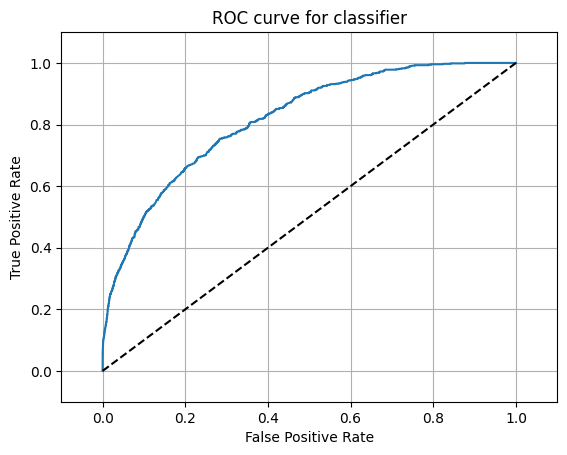

AUC Score: 0.8175971997022272


<Figure size 800x600 with 0 Axes>

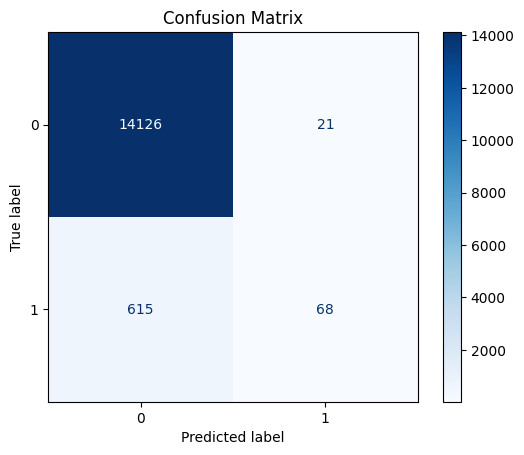

In [12]:
#load the model and check the accuracy, recall, precision, f1-score, and plot the confusion matrix and ROC curve
stacking_model_file = "Ensemble models\V1_Ensemble_stacking_model_imb.pkl"
loaded_stacking_model = joblib.load(stacking_model_file)
y_pred_test = loaded_stacking_model.predict(x_test)
print('Accuracy: ', accuracy_score(y_test, y_pred_test) * 100)
print('Precision: ', precision_score(y_test, y_pred_test) * 100)
print('Recall: ', recall_score(y_test, y_pred_test) * 100)
print('F1-Score: ', f1_score(y_test, y_pred_test) * 100)

# Compute ROC curve and AUC score
y_pred_prob = loaded_stacking_model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('ROC curve for classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

print("AUC Score:", roc_auc_score(y_test, y_pred_prob))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=loaded_stacking_model.classes_)
cm_display.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [29]:
import winsound
# Play a sound to indicate the end of the process
winsound.MessageBeep()